# Qualité des calages

Les dépenses ou quantités agrégées de Budget des Familles après calage, avec celles de la comptabilité nationale. Le calage est effectué sur les dépenses en carburants.

In [29]:
# Import de modules généraux
from __future__ import division

import pkg_resources
import os
import pandas as pd
from pandas import concat
import seaborn

# modules spécifiques
from openfisca_france_indirect_taxation.examples.utils_example import graph_builder_line

# from ipp_macro_series_parser.agregats_transports.transports_cleaner import g2_1
from openfisca_france_indirect_taxation.examples.utils_example import get_input_data_frame, graph_builder_line


# palette de couleurs
seaborn.set_palette(seaborn.color_palette("Set2", 12))
%matplotlib inline

# un chemin utile
assets_directory = os.path.join(
    pkg_resources.get_distribution('openfisca_france_indirect_taxation').location,
    'openfisca_france_indirect_taxation', 
    'assets'
    )

## Transport et carburants
### Dépenses agrégées issue de l'enquête Budget des familles

In [30]:
# Création d'une table à partir du fichiers csv des montants agrégés des dépenses de l'enquêtes BdF.
# Ces montants sont calculés dans compute_depenses_carburants

products = ['transports', 'carburants', 'essence', 'diesel']
depenses_bdf = pd.DataFrame()
for product in products:
    depenses = pd.DataFrame.from_csv(os.path.join(
        assets_directory, 'depenses', 'depenses_{}_totales_bdf.csv'.format(product)),
        sep = ',',
        header = -1
        )
    depenses.rename(columns = {1: '{} bdf'.format(product)}, inplace = True)
    depenses.index = depenses.index.str.replace('en ', '')
    depenses = depenses.sort_index()
    depenses_bdf = concat([depenses, depenses_bdf], axis = 1)

depenses_bdf
depenses_bdf.index = depenses_bdf.index.astype(int)
depenses_bdf.dropna(inplace = True)
depenses_bdf
# TODO améliorer cela (virer la 1ère ligne)

,diesel bdf,essence bdf,carburants bdf,transports bdf
0,,,,
2000,12987.594644,18087.405340,31074.999984,90351.335559
2005,18882.886691,15723.113224,34605.999915,105711.877297
2011,27636.350100,14116.600743,41752.950842,131062.850158


In [36]:
# Import des fichiers csv donnant les montants agrégés des mêmes postes d'après la comptabilité nationale

parametres_fiscalite_file_path = os.path.join(
    assets_directory,
    'legislation',
    'Parametres fiscalite indirecte.xls'
    )
masses_cn_data_frame = pd.read_excel(parametres_fiscalite_file_path, sheetname = "consommation_CN")

masses_cn_carburants = masses_cn_data_frame[masses_cn_data_frame['Fonction'] == 'Carburants et lubrifiants'].transpose()
masses_cn_carburants.rename(columns = {76: 'carburants agregat'}, inplace = True)

masses_cn_transports = masses_cn_data_frame[masses_cn_data_frame['Fonction'] == 'Transports'].transpose()
masses_cn_transports.rename(columns = {69: 'transports agregat'}, inplace = True)

comparaison_bdf_agregats = concat([depenses_bdf, masses_cn_carburants, masses_cn_transports], axis = 1).dropna()
comparaison_bdf_agregats

,diesel bdf,essence bdf,carburants bdf,transports bdf,carburants agregat,transports agregat
2000,12987.594644,18087.405340,31074.999984,90351.335559,31075.7,116130
2005,18882.886691,15723.113224,34605.999915,105711.877297,34606,136837
2011,27636.350100,14116.600743,41752.950842,131062.850158,41765.9,160316


## Comparaison des dépenses agrégées de carburant

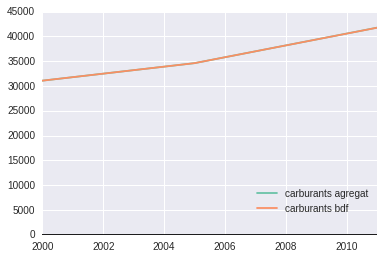

In [37]:
graph_builder_line(comparaison_bdf_agregats[['carburants agregat'] + ['carburants bdf']])

## Comparaison des dépenses agrégées de transports

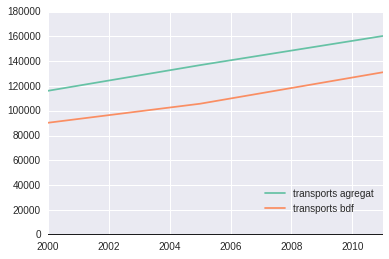

In [38]:
graph_builder_line(comparaison_bdf_agregats[['transports agregat'] + ['transports bdf']])

## Dépenses issues du compte des Transports

In [43]:
comparaison_vehicules = g2_1[g2_1['categorie'] == u'Voitures particulières']
del comparaison_vehicules['categorie']
comparaison_vehicules = comparaison_vehicules.set_index('index')
comparaison_vehicules = comparaison_vehicules.transpose()
comparaison_vehicules.rename(columns = {'Total': 'total agregats', 'dont essence': 'essence agregats',
    'dont Diesel': 'diesel agregats'}, inplace = True)
comparaison_vehicules['diesel bdf'] = 0
comparaison_vehicules['essence bdf'] = 0
comparaison_vehicules['total bdf'] = 0

NameError: name 'g2_1' is not defined

In [44]:
for year in [2000, 2005, 2011]:
    aggregates_data_frame = get_input_data_frame(year)
    df_nombre_vehicules_bdf = aggregates_data_frame[['veh_diesel', 'veh_essence', 'pondmen']]
    nombre_vehicules_diesel_bdf = (
        df_nombre_vehicules_bdf['veh_diesel'] * df_nombre_vehicules_bdf['pondmen']
        ).sum() / 1000
    comparaison_vehicules.loc[comparaison_vehicules.index == year, 'diesel bdf'] = \
        nombre_vehicules_diesel_bdf

    nombre_vehicules_essence_bdf = (
        df_nombre_vehicules_bdf['veh_essence'] * df_nombre_vehicules_bdf['pondmen']
        ).sum() / 1000
    comparaison_vehicules.loc[comparaison_vehicules.index == year, 'essence bdf'] = \
        nombre_vehicules_essence_bdf

    nombre_vehicules_total_bdf = (
        (df_nombre_vehicules_bdf['veh_essence'] + df_nombre_vehicules_bdf['veh_diesel']) *
        df_nombre_vehicules_bdf['pondmen']
        ).sum() / 1000
    comparaison_vehicules.loc[comparaison_vehicules.index == year, 'total bdf'] = \
        nombre_vehicules_total_bdf

comparaison_vehicules = comparaison_vehicules[comparaison_vehicules['total bdf'] != 0]


NameError: name 'comparaison_vehicules' is not defined

In [45]:
print 'Comparaison nombre de véhicules tous types'
graph_builder_line(comparaison_vehicules[['total bdf'] + ['total agregats']])
print 'Comparaison nombre de véhicules diesels'
graph_builder_line(comparaison_vehicules[['diesel bdf'] + ['diesel agregats']])
print 'Comparaison nombre de véhicules essences'
graph_builder_line(comparaison_vehicules[['essence bdf'] + ['essence agregats']])

Comparaison nombre de véhicules tous types


NameError: name 'comparaison_vehicules' is not defined